In [53]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.cluster import KMeans
import random
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## 1) Exploratory Data Analysis and preprocessing

At this stage, we took our cleaned, preprocessed data and found jaccard similarities between the queries and the clicked items. The intent was to analyse the time differences between query and click, and identify if this had anything to do with the "quality" of the query. We pulled our results into Tableau Desktop to create visualizations with this information.

In [54]:
products = pd.read_csv("products_old.csv")

In [55]:
trainall = pd.read_csv("train.csv")

In [56]:
testall = pd.read_csv("test.csv")

In [57]:
train = trainall.drop(['user','category'],axis=1)

In [58]:
train.head()

,sku,query,click_time,query_time
0,2032076,gears of war,2011-10-09 17:22:56.101,2011-10-09 17:21:42.917
1,9854804,Gears of war,2011-09-25 13:35:42.198,2011-09-25 13:35:33.234
2,2670133,Gears of war,2011-09-25 13:36:08.668,2011-09-25 13:35:33.234
3,9984142,Assassin creed,2011-09-25 13:37:23.709,2011-09-25 13:37:00.049
4,2541184,dead island,2011-09-11 15:15:34.336,2011-09-11 15:15:26.206


In [59]:
data = train.merge(products, left_on='sku', right_on='sku',how='inner')

In [60]:
data.shape

(42065, 34)

In [61]:
data['name'] = data.name.str.lower()
data['name'] = data.name.str.replace(r"[^\w\s']",' ')
data['name'] = data.name.str.strip()
data['query'] = data['query'].str.lower()
data['query'] = data['query'].str.replace(r"[^\w\s']",' ')
data['query'] = data['query'].str.strip()

In [62]:
data['click_time'] =  pd.to_datetime(data['click_time'] )
data['query_time'] =  pd.to_datetime(data['query_time'] )
data['time_diff'] = data.click_time - data.query_time
data['time_diff'] = data['time_diff'].dt.total_seconds().astype(int)
data.customerReviewCount = data.customerReviewCount.fillna(0).astype(int)

In [63]:
data = data.drop(['salePrice'],axis=1)

In [64]:
def get_jaccard_sim(x): 
    a = set(x[0].split()) 
    b = set(x[1].split())
    c = a.intersection(b)
    return round(float(len(c)) / (len(a) + len(b) - len(c)),2)

In [65]:
data['name_query_sim'] = data[['name','query']].apply(get_jaccard_sim,axis=1)

In [66]:
data

,sku,query,click_time,query_time,index,productId,name,new,regularPrice,customerReviewCount,...,onlineAvailability_businessDay12,esrb_everyone10,esrb_everyone,esrb_mature,esrb_pending,esrb_teen,genre,esrb_description,time_diff,name_query_sim
0,2032076,gears of war,2011-10-09 17:22:56.101,2011-10-09 17:21:42.917,177,1.218310e+12,gears of war triple pack,0,29.99,15,...,0,0,0,1,0,0,shooter,blood gore intens violenc strong languag,73,0.60
1,2032076,xbox 360,2011-09-23 16:22:41.255,2011-09-23 16:19:20.925,177,1.218310e+12,gears of war triple pack,0,29.99,15,...,0,0,0,1,0,0,shooter,blood gore intens violenc strong languag,200,0.00
2,2032076,gears of war,2011-09-24 13:05:36.624,2011-09-24 13:05:02.961,177,1.218310e+12,gears of war triple pack,0,29.99,15,...,0,0,0,1,0,0,shooter,blood gore intens violenc strong languag,33,0.60
3,2032076,gears of war triple pack,2011-09-04 20:09:04.395,2011-09-04 20:08:47.268,177,1.218310e+12,gears of war triple pack,0,29.99,15,...,0,0,0,1,0,0,shooter,blood gore intens violenc strong languag,17,1.00
4,2032076,gears of war,2011-09-30 08:59:47.095,2011-09-30 08:58:28.462,177,1.218310e+12,gears of war triple pack,0,29.99,15,...,0,0,0,1,0,0,shooter,blood gore intens violenc strong languag,78,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42060,3838112,king of figthers,2011-10-26 16:41:54.847,2011-10-26 16:41:28.657,543,1.218440e+12,the king of fighters xiii,0,39.99,0,...,0,0,0,0,0,1,fight,mild languag suggest theme use alcohol violenc,26,0.33
42061,3838112,king of fighters xbox,2011-10-28 10:12:57.654,2011-10-28 10:12:05.422,543,1.218440e+12,the king of fighters xiii,0,39.99,0,...,0,0,0,0,0,1,fight,mild languag suggest theme use alcohol violenc,52,0.50
42062,8947768,infinite undiscovery,2011-09-18 12:43:20.129,2011-09-18 12:43:16.139,641,1.215820e+12,infinite undiscovery,0,19.99,6,...,0,0,0,0,0,1,role play,mild blood mild languag suggest theme use alco...,3,1.00
42063,9977237,xbox 360 white,2011-10-15 17:52:58.697,2011-10-15 17:52:53.692,857,1.218200e+12,shaun white skateboarding,0,9.50,1,...,0,0,0,0,0,1,sport outdoor,mild languag mild suggest theme mild violenc,5,0.20


In [67]:
data.columns

Index(['sku', 'query', 'click_time', 'query_time', 'index', 'productId',
       'name', 'new', 'regularPrice', 'customerReviewCount',
       'customerReviewAverage', 'freeShipping', 'onlineAvailability',
       'onlineAvailabilityText', 'releaseDate', 'shippingCost',
       'shortDescription', 'manufacturer', 'inStorePickup', 'esrbRating',
       'longDescription', 'onlineAvailability_notAvailable',
       'onlineAvailability_preOrder', 'onlineAvailability_soldOut',
       'onlineAvailability_businessDay1', 'onlineAvailability_businessDay12',
       'esrb_everyone10', 'esrb_everyone', 'esrb_mature', 'esrb_pending',
       'esrb_teen', 'genre', 'esrb_description', 'time_diff',
       'name_query_sim'],
      dtype='object')

In [68]:
data[['sku','name','new','regularPrice','customerReviewCount','customerReviewAverage','freeShipping',
      'onlineAvailability','releaseDate','shippingCost','manufacturer','inStorePickup','onlineAvailability_notAvailable',
      'onlineAvailability_preOrder','onlineAvailability_soldOut','onlineAvailability_businessDay1',
      'onlineAvailability_businessDay12','esrb_everyone10','esrb_everyone','esrb_mature','esrb_pending','esrb_teen',
      'time_diff','name_query_sim']]

,sku,name,new,regularPrice,customerReviewCount,customerReviewAverage,freeShipping,onlineAvailability,releaseDate,shippingCost,...,onlineAvailability_soldOut,onlineAvailability_businessDay1,onlineAvailability_businessDay12,esrb_everyone10,esrb_everyone,esrb_mature,esrb_pending,esrb_teen,time_diff,name_query_sim
0,2032076,gears of war triple pack,0,29.99,15,4.8,1,1,2/15/2011,0.0,...,0,1,0,0,0,1,0,0,73,0.60
1,2032076,gears of war triple pack,0,29.99,15,4.8,1,1,2/15/2011,0.0,...,0,1,0,0,0,1,0,0,200,0.00
2,2032076,gears of war triple pack,0,29.99,15,4.8,1,1,2/15/2011,0.0,...,0,1,0,0,0,1,0,0,33,0.60
3,2032076,gears of war triple pack,0,29.99,15,4.8,1,1,2/15/2011,0.0,...,0,1,0,0,0,1,0,0,17,1.00
4,2032076,gears of war triple pack,0,29.99,15,4.8,1,1,2/15/2011,0.0,...,0,1,0,0,0,1,0,0,78,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42060,3838112,the king of fighters xiii,0,39.99,0,NaN,1,0,11/22/2011,0.0,...,0,0,0,0,0,0,0,1,26,0.33
42061,3838112,the king of fighters xiii,0,39.99,0,NaN,1,0,11/22/2011,0.0,...,0,0,0,0,0,0,0,1,52,0.50
42062,8947768,infinite undiscovery,0,19.99,6,4.2,1,0,9/2/2008,NaN,...,0,0,0,0,0,0,0,1,3,1.00
42063,9977237,shaun white skateboarding,0,9.50,1,3.0,1,1,10/24/2010,0.0,...,0,1,0,0,0,0,0,1,5,0.20


In [69]:
data = data.dropna(subset=['shortDescription','longDescription'])

In [70]:
data['description'] = data['shortDescription'].astype(str) + ' ' + data['longDescription'].astype(str)
data[['shortDescription','longDescription','description']].sample(15)

C:\Users\ayush\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,shortDescription,longDescription,description
6898,find happen zombi outbreak hit tropic island p...,beach bunni parad around sand skimpi bikini wa...,find happen zombi outbreak hit tropic island p...
2224,fight surviv human race,learn gear war 3 flash demo synopsisth hope hu...,fight surviv human race learn gear war 3 flash...
35080,take fight next level,learn call duti modern warfar 2 flash demo syn...,take fight next level learn call duti modern w...
485,fight surviv human race,learn gear war 3 flash demo synopsisth hope hu...,fight surviv human race learn gear war 3 flash...
12853,live action sunday everi day week,decad one name defin nfl game authent footbal ...,live action sunday everi day week decad one na...
38003,zip past competit blow,learn blur flash demo synopsisyou feel satisfi...,zip past competit blow learn blur flash demo s...
31281,kill skill fight reveng,member elit peacekeep forc dead echo grayson h...,kill skill fight reveng member elit peacekeep ...
10910,dark knight return epic follow,night fall gotham seedi undergrowth citi emerg...,dark knight return epic follow night fall goth...
4439,prepar harrow intens war epic sequel,fight surviv ensur mission success keep fellow...,prepar harrow intens war epic sequel fight sur...
14634,readi becom next great legend,snow fall pittsburgh heinz field feel rush adr...,readi becom next great legend snow fall pittsb...


In [71]:
desc = CountVectorizer(ngram_range=(1,2)).fit_transform(data.description)

In [72]:
desc.shape

(42064, 46383)

In [73]:
len(products.manufacturer.unique())

56

description (short+long), manufactturer - dummies, esrb rating

In [74]:
products['description'] = products['shortDescription'].astype(str) + ' ' + products['longDescription'].astype(str)
products['description'] = products['description'].apply(lambda x: re.sub(r'\w*\d\w*', '',x))

In [75]:
manufacturerDum = pd.get_dummies(products.manufacturer,drop_first=True)

In [76]:
products1 = products[['esrb_everyone10', 'esrb_everyone', 'esrb_mature', 'esrb_pending','esrb_teen']]
products2 = pd.merge(products1,manufacturerDum,left_index=True,right_index=True)

In [77]:
vec = CountVectorizer(ngram_range=(1,2))
desc = vec.fit_transform(products.description)
descdf = pd.DataFrame.from_records(desc.toarray(),columns=vec.get_feature_names())

In [78]:
products3 = pd.merge(products2,descdf,left_index=True,right_index=True)

In [79]:
genreDum = pd.get_dummies(products.genre)
genreDum = genreDum.drop(['na'],axis=1)

In [80]:
products4 = pd.merge(products3,genreDum,left_index=True,right_index=True)

In [81]:
vec2 = CountVectorizer(ngram_range=(1,2))
esrbdesc = vec2.fit_transform(products.esrb_description)
esrbdescdf = pd.DataFrame.from_records(esrbdesc.toarray(),columns=vec2.get_feature_names())

In [82]:
products5 = pd.merge(products4,esrbdescdf,left_index=True,right_index=True)

## Best Match Product

In [83]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.cluster import KMeans
import scipy
import math
import re
from collections import Counter
import operator
from collections import defaultdict
from collections import deque

In [84]:
products = pd.read_csv("products_old.csv")
trainall = pd.read_csv("train.csv")
testall = pd.read_csv("test.csv")

In [85]:
train = trainall.drop(['click_time','query_time','category','sku'],axis=1)
test = testall.drop(['category','click_time','query_time'],axis=1)

In [86]:
user_query = [train,test]
user_query = pd.concat(user_query)
user_query

,user,query
0,0001cd0d10bbc585c9ba287c963e00873d4c0bfd,gears of war
1,00033dbced6acd3626c4b56ff5c55b8d69911681,Gears of war
2,00033dbced6acd3626c4b56ff5c55b8d69911681,Gears of war
3,00033dbced6acd3626c4b56ff5c55b8d69911681,Assassin creed
4,0007756f015345450f7be1df33695421466b7ce4,dead island
...,...,...
28236,fff90d259bc0e6d25f52270efa6ffe39cbb3f4ec,Hunted
28237,fffa50e2b4675b457e86e1c756ed85c4d2bdf5e0,Need for speed
28238,fffa95be88e8210312518a884d14e39e13d727eb,Rocksmith
28239,fffb154d387316747181e5d647c0b7eac8f6e064,Dead island


In [87]:
products = products.drop(['new','regularPrice','customerReviewCount','customerReviewAverage','freeShipping',
      'onlineAvailability','releaseDate','shippingCost','manufacturer','inStorePickup','onlineAvailability_notAvailable',
      'onlineAvailability_preOrder','onlineAvailability_soldOut','onlineAvailability_businessDay1',
      'onlineAvailability_businessDay12','esrb_everyone10','esrb_everyone','esrb_mature','esrb_pending','esrb_teen','salePrice', 'onlineAvailabilityText', 'shortDescription', 'esrbRating',
       'longDescription', 'genre', 'esrb_description','productId','index'],axis=1)

In [88]:
products['name'] = products.name.str.lower()
products['name'] = products.name.str.replace(r"[^\w\s']",' ')
products['name'] = products.name.str.strip()
train['query'] = train['query'].str.lower()
train['query'] = train['query'].str.replace(r"[^\w\s']",' ')
train['query'] = train['query'].str.strip()

In [89]:
name_to_sku_dt = {x[1]:x[0] for x in zip(products.sku, products.name)}
name_to_sku_dt

{'sniper  ghost warrior': 1004622,
 'monopoly streets': 1010544,
 'mysims  skyheroes': 1011067,
 'fifa soccer 11': 1011491,
 'hasbro family game night 3': 1011831,
 'the sims 3': 1012721,
 'two worlds ii': 1012876,
 'call of duty  the war collection': 1013666,
 'castlevania  lords of shadow': 1014064,
 'need for speed  hot pursuit': 1032361,
 'marvel vs  capcom 3  fate of two worlds': 1052221,
 'guitar hero  warriors of rock': 1066233,
 'dj hero 2': 1066515,
 'wwe smackdown vs  raw 2011': 1066551,
 'homefront': 1067848,
 'red faction  armageddon': 1067948,
 'mortal kombat': 1078792,
 'driver san francisco': 1092494,
 'spider man  shattered dimensions': 1094401,
 'lucha libre aaa  heroes del ring': 1121355,
 'def jam rapstar': 1121373,
 'darkstar one  broken alliance': 1142357,
 "star wars  the force unleashed ii collector's edition": 1154546,
 'nba 2k11': 1161734,
 'blood stone 007': 1170735,
 'your shape  fitness evolved': 1179927,
 'kinect joy ride': 1179963,
 'kinectimals': 1180061,

In [90]:
WORD = re.compile(r"\w+")


def get_cosine(text1, text2):
    vec1 = text_to_vector(text1)
    vec2 = text_to_vector(text2)
    
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

def get_jaccard_sim(text1, text2): 
    text1 = text1.lower()
    text2 = text2.lower()
    a = set(text1.split()) 
    b = set(text2.split())
    c = a.intersection(b)
    return round(float(len(c)) / (len(a) + len(b) - len(c)),2)

#best match based on jaccard's similarity
def find_best_match(query_text):
    max_val = 0
    best_match_name = []
    for name in products['name'].unique():
        cos_val = get_jaccard_sim(query_text, name)
        if cos_val > 0 and cos_val >= max_val:
            max_val = cos_val
            best_match_name.append([name, cos_val])
    if len(best_match_name) == 0:
        return "No Matches"
    else:
        best_match_name.sort(key=lambda x: (x[1], x[0]), reverse=True)
    return best_match_name[0][0]


In [91]:
user_query['best_match'] = user_query['query'].apply(find_best_match)

In [92]:
def ret_sku(name):
    return name_to_sku_dt[name]

def ret_sku_count(sku):
    return game_pop[sku]

In [93]:
user_query = user_query[user_query.best_match != "No Matches"]
user_query['match_sku'] = user_query['best_match'].apply(ret_sku)
user_query

C:\Users\ayush\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user,query,best_match,match_sku
0,0001cd0d10bbc585c9ba287c963e00873d4c0bfd,gears of war,gears of war 3,9854804
1,00033dbced6acd3626c4b56ff5c55b8d69911681,Gears of war,gears of war 3,9854804
2,00033dbced6acd3626c4b56ff5c55b8d69911681,Gears of war,gears of war 3,9854804
3,00033dbced6acd3626c4b56ff5c55b8d69911681,Assassin creed,assassin's creed brotherhood,9984142
4,0007756f015345450f7be1df33695421466b7ce4,dead island,dead island,2541184
...,...,...,...,...
28236,fff90d259bc0e6d25f52270efa6ffe39cbb3f4ec,Hunted,jurassic the hunted,9629647
28237,fffa50e2b4675b457e86e1c756ed85c4d2bdf5e0,Need for speed,need for speed the run,2678241
28238,fffa95be88e8210312518a884d14e39e13d727eb,Rocksmith,rocksmith best buy exclusive edition,2633149
28239,fffb154d387316747181e5d647c0b7eac8f6e064,Dead island,dead island,2541184


## Clustering and Ranking the products in each cluster
Picking TfidfVectorizer from our four sets of features because there is better set of distribution of products across clusters. We also use cluster size of 13.

We found that the behavious of our users was erratic, there was no fixed pattern to their clicking habits so we couldn't lump them into "similar users" based on their clicks. Therefore, we decided to proceed with content-based filtering. For this purpose, we had to use our products catalog and form clusters of similar products based on 6 different data signals (ESRB rating, ESRB descriptor, Genre, short description, long description, manufacturer).

We ensured that the clusters only contained products above a certain customer rating, and that all products were sorted in descending order of popularity (calculated by total number of searches).

In [94]:
products = pd.read_csv("products_old.csv")

In [95]:
products['description'] = products['shortDescription'].astype(str) + ' ' + products['longDescription'].astype(str)
products['description'] = products['description'].apply(lambda x: re.sub(r'\w*\d\w*', '',x))
manufacturerDum = pd.get_dummies(products.manufacturer,drop_first=True)
products1 = products[['esrb_everyone10', 'esrb_everyone', 'esrb_mature', 'esrb_pending','esrb_teen']]
products2 = pd.merge(products1,manufacturerDum,left_index=True,right_index=True)
vec = TfidfVectorizer(ngram_range=(1,2))
desc = vec.fit_transform(products.description)
descdf = pd.DataFrame.from_records(desc.toarray(),columns=vec.get_feature_names())
products3 = pd.merge(products2,descdf,left_index=True,right_index=True)
genreDum = pd.get_dummies(products.genre)
genreDum = genreDum.drop(['na'],axis=1)
products4 = pd.merge(products3,genreDum,left_index=True,right_index=True)
vec2 = TfidfVectorizer(ngram_range=(1,2))
esrbdesc = vec2.fit_transform(products.esrb_description)
esrbdescdf = pd.DataFrame.from_records(esrbdesc.toarray(),columns=vec2.get_feature_names())
tfidfUniBi = pd.merge(products4,esrbdescdf,left_index=True,right_index=True)

In [96]:
kmeans = KMeans(n_clusters=13, random_state=0).fit(tfidfUniBi)
cluster_map = pd.DataFrame()
cluster_map['products_index'] = tfidfUniBi.index.values
cluster_map['cluster'] = kmeans.labels_

In [97]:
pca = PCA(n_components= 2)
scatter_plot_points = pca.fit_transform(tfidfUniBi.values)

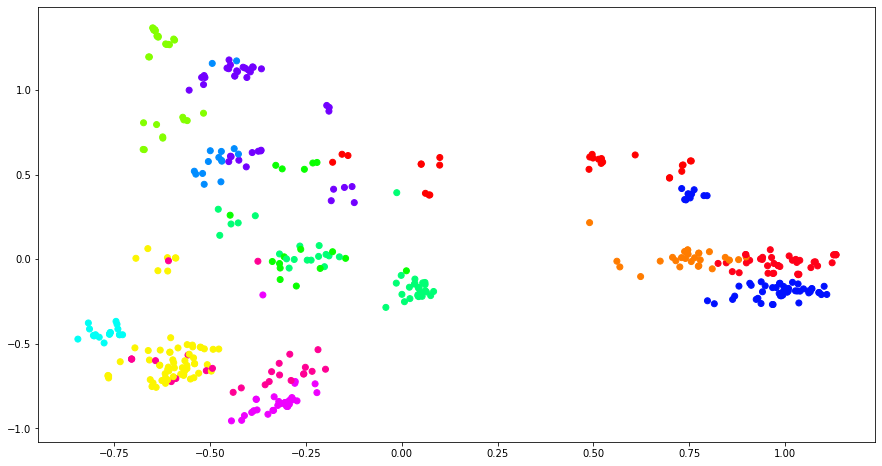

In [98]:
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(15,8))

ax.scatter(x_axis, y_axis, c = kmeans.labels_, cmap = 'hsv')

In [99]:
cluster_map.shape

(436, 2)

In [100]:
cluster_map['name'] = products['name'].str.lower()
cluster_map['name'] = cluster_map.name.str.replace(r"[^\w\s']",' ')
cluster_map['name'] = cluster_map.name.str.strip()

In [101]:
cluster_map.isna().sum()

products_index    0
cluster           0
name              0
dtype: int64

In [102]:
no_of_clicks = pd.DataFrame(user_query.groupby('best_match').size().sort_values(ascending = False).reset_index(name = 'count'))
no_of_clicks = no_of_clicks.rename(columns = {'best_match': 'name'})

In [103]:
no_of_clicks

,name,count
0,gears of war 3,6969
1,batman arkham city,5053
2,xbox live arcade triple pack,4048
3,dead island,3992
4,battlefield 3,3476
...,...,...
391,dead to rights platinum hits,1
392,darksiders ii limited edition,1
393,winter stars,1
394,call of duty 4 modern warfare game of the yea...,1


In [104]:
cluster_map

,products_index,cluster,name
0,0,0,sniper ghost warrior
1,1,9,monopoly streets
2,2,5,mysims skyheroes
3,3,3,fifa soccer 11
4,4,9,hasbro family game night 3
...,...,...,...
431,431,2,test drive unlimited 2
432,432,8,l a noire
433,433,6,shaun white skateboarding
434,434,10,star wars the force unleashed


In [105]:
cluster_prod_counts = pd.merge(cluster_map, no_of_clicks, on = 'name', how = 'inner')
print(cluster_prod_counts)
cluster_prod_counts = cluster_prod_counts.drop_duplicates('name').reset_index().drop('index', axis = 1)

     products_index  cluster                              name  count
0                 0        0             sniper  ghost warrior     69
1                 1        9                  monopoly streets     20
2                 3        3                    fifa soccer 11     48
3                 4        9        hasbro family game night 3     29
4                 5        2                        the sims 3    272
..              ...      ...                               ...    ...
395             430        3  backyard sports sandlot sluggers      1
396             431        2            test drive unlimited 2     87
397             432        8                        l a  noire     96
398             433        6         shaun white skateboarding     10
399             435        8      assassin's creed brotherhood    514

[400 rows x 4 columns]


In [106]:
cluster_prod_counts

,products_index,cluster,name,count
0,0,0,sniper ghost warrior,69
1,1,9,monopoly streets,20
2,3,3,fifa soccer 11,48
3,4,9,hasbro family game night 3,29
4,5,2,the sims 3,272
...,...,...,...,...
391,430,3,backyard sports sandlot sluggers,1
392,431,2,test drive unlimited 2,87
393,432,8,l a noire,96
394,433,6,shaun white skateboarding,10


In [107]:
cluster_prod_counts.sort_values(by = ['cluster', 'count'], ascending = False)

,products_index,cluster,name,count
374,412,12,gears of war 3,6969
248,268,12,battlefield 3,3476
133,141,12,call of duty modern warfare 3,2802
379,418,12,call of duty black ops,2078
34,37,12,rage,779
...,...,...,...,...
329,363,0,call of duty modern warfare 2 hardened edition,2
352,389,0,x360 stoked big air edition,2
213,228,0,prey 2,1
269,297,0,kengo legend of the 9,1


In [108]:
cluster_df = cluster_prod_counts.groupby('cluster').size().reset_index(name = 'no_of_products')

In [109]:
cluster_df

,cluster,no_of_products
0,0,25
1,1,24
2,2,55
3,3,31
4,4,16
5,5,39
6,6,17
7,7,14
8,8,52
9,9,34


In [110]:
import seaborn as sns

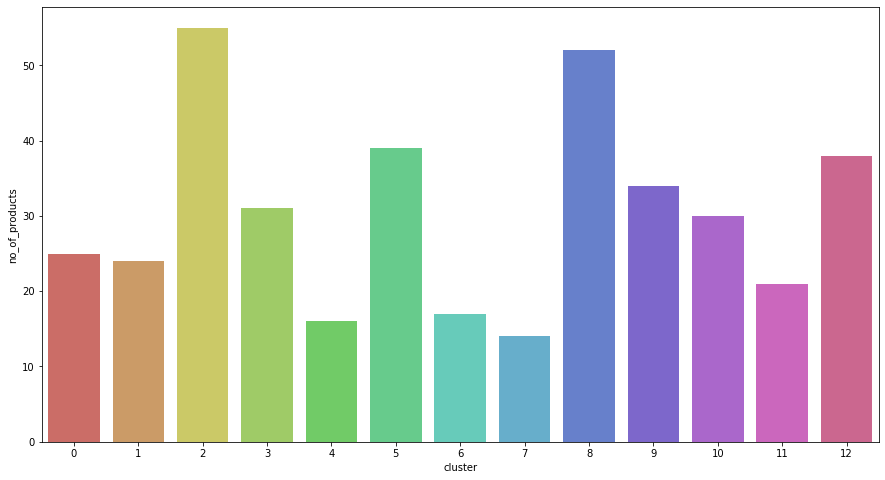

In [111]:
plt.figure(figsize = (15, 8))
sns.barplot(x = 'cluster', y = 'no_of_products', data = cluster_df, palette = 'hls')

## Spell check

For each user, we eliminated duplicate queries and compiled their searches. 
Despite these operations, there were quite a few queries which differed by a couple of character or words but were ultimately refering to the same product. In order to address this, we matched all the queries to actual product titles in our catalog. 


In [112]:
gkk = user_query.groupby(['user'])['best_match'].unique().apply(lambda name: ','.join(name)).reset_index()
def turn_to_set(names):
    ls = names.split(',')
    return set(ls)
gkk['best_match'] = gkk['best_match'].apply(lambda x: turn_to_set(x))
gkk['search_count'] = gkk['best_match'].apply(lambda x: len(x))
gkk = gkk.sort_values(by = ['search_count'], ascending = False)
gkk

,user,best_match,search_count
5132,182981fb79c8eb2f7a1bec348ad7d98ee3904e9a,"{wwe '12, lucha libre aaa heroes del ring, ea...",8
1168,0595836394e319c5d3ade94d344fb61960067b5e,"{left 4 dead 2, saints row 2, halo reach, wwe...",8
39036,b7f954b52d855773ca65e03bb534d878bcc0504e,"{call of duty modern warfare 3, borderlands 2...",7
49735,ea526e1e06a48f8645645f32a21099753514a015,"{tom clancy's splinter cell conviction, medal...",7
34789,a417c9185517818334caa2a80383e7da24e3b15b,"{tom clancy's ghost recon future soldier, nee...",7
...,...,...,...
18691,5829f2800c46f7df04b396ea31ceb44e4f9aec9b,{carnival games monkey see monkey do},1
18692,582acb989c4cda3a525e81ff755b668969787536,{gears of war 3},1
18693,582b2f10711ad0664e303c7c9c7ec69311617d04,{kinect sports},1
18694,582c451556437696970f8796743c9d96d94e6bfa,{kinect sports},1


In [113]:
cluster_prod_counts = cluster_prod_counts.sort_values(by = ['cluster', 'count'], ascending = False)
cluster_prod_counts

,products_index,cluster,name,count
374,412,12,gears of war 3,6969
248,268,12,battlefield 3,3476
133,141,12,call of duty modern warfare 3,2802
379,418,12,call of duty black ops,2078
34,37,12,rage,779
...,...,...,...,...
329,363,0,call of duty modern warfare 2 hardened edition,2
352,389,0,x360 stoked big air edition,2
213,228,0,prey 2,1
269,297,0,kengo legend of the 9,1


The piece of code below extracts the ten most popular items from each cluster.

In [114]:
cluster_cnt, cluster_recs = defaultdict(int), defaultdict(list)
name_cluster_dt = defaultdict(int)
def create_cluster_recs():
    for clt, name in zip(cluster_prod_counts.cluster, cluster_prod_counts.name):
        if cluster_cnt[clt] <= 10:
            cluster_recs[clt].append(name)
            cluster_cnt[clt] += 1
        name_cluster_dt[name] = clt
create_cluster_recs()
cluster_recs

defaultdict(list,
            {12: ['gears of war 3',
              'battlefield 3',
              'call of duty  modern warfare 3',
              'call of duty  black ops',
              'rage',
              'call of duty  modern warfare 3 hardened edition',
              'deus ex  human revolution',
              'halo 3  odst',
              'borderlands',
              'gears of war 3  epic edition',
              'call of duty  modern warfare 2'],
             11: ['rocksmith best buy exclusive edition',
              'driver san francisco',
              'call of duty 3  gold edition',
              'brink',
              'the gunstringer',
              'transformers  war for cybertron',
              'g i  joe  the rise of cobra',
              'goldeneye 007  reloaded',
              'the black eyed peas experience',
              'air conflicts  secret wars',
              'rocksmith best buy exclusive edition guitar kit'],
             10: ['batman  arkham city',
          

In [115]:
test = gkk[gkk.search_count >= 3]
test

,user,best_match,search_count
5132,182981fb79c8eb2f7a1bec348ad7d98ee3904e9a,"{wwe '12, lucha libre aaa heroes del ring, ea...",8
1168,0595836394e319c5d3ade94d344fb61960067b5e,"{left 4 dead 2, saints row 2, halo reach, wwe...",8
39036,b7f954b52d855773ca65e03bb534d878bcc0504e,"{call of duty modern warfare 3, borderlands 2...",7
49735,ea526e1e06a48f8645645f32a21099753514a015,"{tom clancy's splinter cell conviction, medal...",7
34789,a417c9185517818334caa2a80383e7da24e3b15b,"{tom clancy's ghost recon future soldier, nee...",7
...,...,...,...
36942,adf51babc509e0d38184a3f964bd0787aa4d9780,"{call of duty modern warfare 3, batman arkha...",3
8904,29f4170c4e3e6b4e97005f456c024f704cdf8755,"{silent hill downpour, batman arkham city, r...",3
35453,a7082e1aa0d3bfb43ca6d347d9ba6fcd58a98775,"{rapala for kinect, xbox live arcade triple pa...",3
40596,bf0e4d13f0abc8ce8bb8f55ad3306f27f37734f4,"{assassin's creed brotherhood, mass effect 3, ...",3


In [116]:
def create_interim(check):
    if len(check) > 3:
        n = 2
    else:
        n = 1
    val = set(random.choices(tuple(check), k = n))
    check = check.difference(val)
    return [check, val]

def create_train(interim):
    return interim[0]

def create_val(interim):
    return interim[1]

test['inter'] = test['best_match'].apply(lambda x: create_interim(x))
test['training'] = test['inter'].apply(lambda x: create_train(x))
test['validation'] = test['inter'].apply(lambda x: create_val(x))
test

C:\Users\ayush\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\ayush\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ayush\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,user,best_match,search_count,inter,training,validation
5132,182981fb79c8eb2f7a1bec348ad7d98ee3904e9a,"{wwe '12, lucha libre aaa heroes del ring, ea...",8,"[{lucha libre aaa heroes del ring, vancouver ...","{lucha libre aaa heroes del ring, vancouver 2...","{wwe '12, ea sports mma}"
1168,0595836394e319c5d3ade94d344fb61960067b5e,"{left 4 dead 2, saints row 2, halo reach, wwe...",8,"[{saints row 2, halo reach, wwe smackdown vs ...","{saints row 2, halo reach, wwe smackdown vs ...","{left 4 dead 2, brink}"
39036,b7f954b52d855773ca65e03bb534d878bcc0504e,"{call of duty modern warfare 3, borderlands 2...",7,"[{call of duty modern warfare 3, borderlands ...","{call of duty modern warfare 3, borderlands 2...",{rise of nightmares}
49735,ea526e1e06a48f8645645f32a21099753514a015,"{tom clancy's splinter cell conviction, medal...",7,"[{medal of honor, gears of war 3, assassin's c...","{medal of honor, gears of war 3, assassin's cr...","{homefront, fallout new vegas}"
34789,a417c9185517818334caa2a80383e7da24e3b15b,"{tom clancy's ghost recon future soldier, nee...",7,"[{tom clancy's ghost recon future soldier, ne...","{tom clancy's ghost recon future soldier, nee...","{dirt 3, halo reach}"
...,...,...,...,...,...,...
36942,adf51babc509e0d38184a3f964bd0787aa4d9780,"{call of duty modern warfare 3, batman arkha...",3,"[{call of duty modern warfare 3, batman arkh...","{call of duty modern warfare 3, batman arkha...",{gears of war 3}
8904,29f4170c4e3e6b4e97005f456c024f704cdf8755,"{silent hill downpour, batman arkham city, r...",3,"[{silent hill downpour, rage}, {batman arkha...","{silent hill downpour, rage}",{batman arkham city}
35453,a7082e1aa0d3bfb43ca6d347d9ba6fcd58a98775,"{rapala for kinect, xbox live arcade triple pa...",3,"[{rapala for kinect, xbox live arcade triple p...","{rapala for kinect, xbox live arcade triple pack}",{rage}
40596,bf0e4d13f0abc8ce8bb8f55ad3306f27f37734f4,"{assassin's creed brotherhood, mass effect 3, ...",3,"[{assassin's creed brotherhood, mass effect 3}...","{assassin's creed brotherhood, mass effect 3}",{metal gear solid hd collection}


In [117]:
test = test.drop('inter', axis = 1)
test

,user,best_match,search_count,training,validation
5132,182981fb79c8eb2f7a1bec348ad7d98ee3904e9a,"{wwe '12, lucha libre aaa heroes del ring, ea...",8,"{lucha libre aaa heroes del ring, vancouver 2...","{wwe '12, ea sports mma}"
1168,0595836394e319c5d3ade94d344fb61960067b5e,"{left 4 dead 2, saints row 2, halo reach, wwe...",8,"{saints row 2, halo reach, wwe smackdown vs ...","{left 4 dead 2, brink}"
39036,b7f954b52d855773ca65e03bb534d878bcc0504e,"{call of duty modern warfare 3, borderlands 2...",7,"{call of duty modern warfare 3, borderlands 2...",{rise of nightmares}
49735,ea526e1e06a48f8645645f32a21099753514a015,"{tom clancy's splinter cell conviction, medal...",7,"{medal of honor, gears of war 3, assassin's cr...","{homefront, fallout new vegas}"
34789,a417c9185517818334caa2a80383e7da24e3b15b,"{tom clancy's ghost recon future soldier, nee...",7,"{tom clancy's ghost recon future soldier, nee...","{dirt 3, halo reach}"
...,...,...,...,...,...
36942,adf51babc509e0d38184a3f964bd0787aa4d9780,"{call of duty modern warfare 3, batman arkha...",3,"{call of duty modern warfare 3, batman arkha...",{gears of war 3}
8904,29f4170c4e3e6b4e97005f456c024f704cdf8755,"{silent hill downpour, batman arkham city, r...",3,"{silent hill downpour, rage}",{batman arkham city}
35453,a7082e1aa0d3bfb43ca6d347d9ba6fcd58a98775,"{rapala for kinect, xbox live arcade triple pa...",3,"{rapala for kinect, xbox live arcade triple pack}",{rage}
40596,bf0e4d13f0abc8ce8bb8f55ad3306f27f37734f4,"{assassin's creed brotherhood, mass effect 3, ...",3,"{assassin's creed brotherhood, mass effect 3}",{metal gear solid hd collection}


## Generate recommendations

Our final algorithm pulls 10 recommendations for each user. Based on products which a user is more likely to search for, these recommendations are proportionately weighted for each cluster.

The last step is to check whether our validation products are present in our top 10 recommendations, and if yes, how many.

In [118]:
#cluster_recs
#name_cluster_dt
def get_recs(games):
    ls = list(games)
    game_clusters = Counter([name_cluster_dt[x] for x in ls])
    n = len(ls)
    to_pull = {key:round((game_clusters[key]/n) * 10) for key in game_clusters.keys()}
    to_pull = sorted(to_pull.items(), key = lambda x:x[1], reverse = True)
    mrecs = set()
    for (clt, n) in to_pull:
        pulled, ind = 0, 0
        rec_ls = cluster_recs[clt]
        while pulled < n:
            try:
                if rec_ls[ind] in games or rec_ls[ind] in mrecs:
                    ind += 1
                else:
                    mrecs.add(rec_ls[ind])
                    pulled += 1
            except IndexError as error:
                break
                
    return mrecs

test['recommendations'] = test['training'].apply(lambda x: get_recs(x))
test

    

,user,best_match,search_count,training,validation,recommendations
5132,182981fb79c8eb2f7a1bec348ad7d98ee3904e9a,"{wwe '12, lucha libre aaa heroes del ring, ea...",8,"{lucha libre aaa heroes del ring, vancouver 2...","{wwe '12, ea sports mma}","{wwe '12, kinect dance central 2, rock revolu..."
1168,0595836394e319c5d3ade94d344fb61960067b5e,"{left 4 dead 2, saints row 2, halo reach, wwe...",8,"{saints row 2, halo reach, wwe smackdown vs ...","{left 4 dead 2, brink}","{wwe '12, gears of war 3, zumba fitness, kinec..."
39036,b7f954b52d855773ca65e03bb534d878bcc0504e,"{call of duty modern warfare 3, borderlands 2...",7,"{call of duty modern warfare 3, borderlands 2...",{rise of nightmares},"{nhl 12, tom clancy's ghost recon future sold..."
49735,ea526e1e06a48f8645645f32a21099753514a015,"{tom clancy's splinter cell conviction, medal...",7,"{medal of honor, gears of war 3, assassin's cr...","{homefront, fallout new vegas}","{call of duty modern warfare 3, call of duty ..."
34789,a417c9185517818334caa2a80383e7da24e3b15b,"{tom clancy's ghost recon future soldier, nee...",7,"{tom clancy's ghost recon future soldier, nee...","{dirt 3, halo reach}","{nhl 12, call of duty modern warfare 3, call ..."
...,...,...,...,...,...,...
36942,adf51babc509e0d38184a3f964bd0787aa4d9780,"{call of duty modern warfare 3, batman arkha...",3,"{call of duty modern warfare 3, batman arkha...",{gears of war 3},{cabela's survival shadows of katmai with top...
8904,29f4170c4e3e6b4e97005f456c024f704cdf8755,"{silent hill downpour, batman arkham city, r...",3,"{silent hill downpour, rage}",{batman arkham city},"{call of duty modern warfare 3, saints row 2,..."
35453,a7082e1aa0d3bfb43ca6d347d9ba6fcd58a98775,"{rapala for kinect, xbox live arcade triple pa...",3,"{rapala for kinect, xbox live arcade triple pack}",{rage},{cabela's survival shadows of katmai with top...
40596,bf0e4d13f0abc8ce8bb8f55ad3306f27f37734f4,"{assassin's creed brotherhood, mass effect 3, ...",3,"{assassin's creed brotherhood, mass effect 3}",{metal gear solid hd collection},"{saints row 2, the elder scrolls v skyrim, mo..."


In [119]:
goodness = []
for val, rec in zip(test.validation, test.recommendations):
    goodness.append(len(val.intersection(rec))/len(val))
test['goodness'] = goodness
test

,user,best_match,search_count,training,validation,recommendations,goodness
5132,182981fb79c8eb2f7a1bec348ad7d98ee3904e9a,"{wwe '12, lucha libre aaa heroes del ring, ea...",8,"{lucha libre aaa heroes del ring, vancouver 2...","{wwe '12, ea sports mma}","{wwe '12, kinect dance central 2, rock revolu...",0.5
1168,0595836394e319c5d3ade94d344fb61960067b5e,"{left 4 dead 2, saints row 2, halo reach, wwe...",8,"{saints row 2, halo reach, wwe smackdown vs ...","{left 4 dead 2, brink}","{wwe '12, gears of war 3, zumba fitness, kinec...",0.0
39036,b7f954b52d855773ca65e03bb534d878bcc0504e,"{call of duty modern warfare 3, borderlands 2...",7,"{call of duty modern warfare 3, borderlands 2...",{rise of nightmares},"{nhl 12, tom clancy's ghost recon future sold...",0.0
49735,ea526e1e06a48f8645645f32a21099753514a015,"{tom clancy's splinter cell conviction, medal...",7,"{medal of honor, gears of war 3, assassin's cr...","{homefront, fallout new vegas}","{call of duty modern warfare 3, call of duty ...",0.0
34789,a417c9185517818334caa2a80383e7da24e3b15b,"{tom clancy's ghost recon future soldier, nee...",7,"{tom clancy's ghost recon future soldier, nee...","{dirt 3, halo reach}","{nhl 12, call of duty modern warfare 3, call ...",0.0
...,...,...,...,...,...,...,...
36942,adf51babc509e0d38184a3f964bd0787aa4d9780,"{call of duty modern warfare 3, batman arkha...",3,"{call of duty modern warfare 3, batman arkha...",{gears of war 3},{cabela's survival shadows of katmai with top...,1.0
8904,29f4170c4e3e6b4e97005f456c024f704cdf8755,"{silent hill downpour, batman arkham city, r...",3,"{silent hill downpour, rage}",{batman arkham city},"{call of duty modern warfare 3, saints row 2,...",0.0
35453,a7082e1aa0d3bfb43ca6d347d9ba6fcd58a98775,"{rapala for kinect, xbox live arcade triple pa...",3,"{rapala for kinect, xbox live arcade triple pack}",{rage},{cabela's survival shadows of katmai with top...,0.0
40596,bf0e4d13f0abc8ce8bb8f55ad3306f27f37734f4,"{assassin's creed brotherhood, mass effect 3, ...",3,"{assassin's creed brotherhood, mass effect 3}",{metal gear solid hd collection},"{saints row 2, the elder scrolls v skyrim, mo...",0.0


In [120]:
len(test[test.goodness == 0.5])

44

In [121]:
len(test[test.goodness == 1])

130

Of **551 users**, we were able to generate accurate recommendations for **174**. 

130 users got fully accurate recommendations i.e. both their validation products were present in the 10 recommendations, whereas 44 users got half-accurate recommendations i.e. one of their products was present in the recommendations.

By this definition, our model is accurate **32%** of the times.

## Elbow Method
We will use the elbow method to finalize the number of clusters we need for each of our 4 sets of features which are as follows:

### CountVectorizer Unigrams

In [84]:
products['description'] = products['shortDescription'].astype(str) + ' ' + products['longDescription'].astype(str)
products['description'] = products['description'].apply(lambda x: re.sub(r'\w*\d\w*', '',x))
manufacturerDum = pd.get_dummies(products.manufacturer,drop_first=True)
products1 = products[['esrb_everyone10', 'esrb_everyone', 'esrb_mature', 'esrb_pending','esrb_teen']]
products2 = pd.merge(products1,manufacturerDum,left_index=True,right_index=True)
vec = CountVectorizer(ngram_range=(1,1))
desc = vec.fit_transform(products.description)
descdf = pd.DataFrame.from_records(desc.toarray(),columns=vec.get_feature_names())
products3 = pd.merge(products2,descdf,left_index=True,right_index=True)
genreDum = pd.get_dummies(products.genre)
genreDum = genreDum.drop(['na'],axis=1)
products4 = pd.merge(products3,genreDum,left_index=True,right_index=True)
vec2 = CountVectorizer(ngram_range=(1,1))
esrbdesc = vec2.fit_transform(products.esrb_description)
esrbdescdf = pd.DataFrame.from_records(esrbdesc.toarray(),columns=vec2.get_feature_names())
countUni = pd.merge(products4,esrbdescdf,left_index=True,right_index=True)

kmeans done for k= 10
[1, 7, 81, 28, 8, 246, 27, 2, 35, 1]
kmeans done for k= 11
[74, 11, 17, 4, 34, 193, 4, 69, 22, 4, 4]
kmeans done for k= 12
[27, 226, 12, 87, 2, 7, 13, 2, 29, 1, 4, 26]
kmeans done for k= 13
[3, 133, 4, 4, 155, 4, 2, 30, 3, 58, 3, 22, 15]
kmeans done for k= 14
[1, 189, 1, 2, 24, 2, 4, 11, 90, 11, 2, 2, 4, 93]
kmeans done for k= 15
[2, 4, 45, 29, 59, 2, 2, 89, 5, 10, 2, 2, 182, 1, 2]


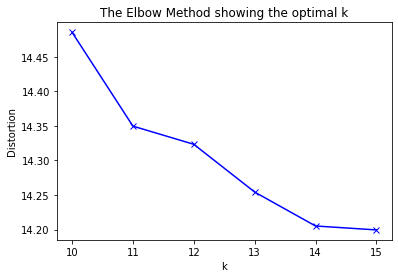

In [6]:
# k means determine k
distortions = []
p = 0
K = range(10,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(countUni)
    kmeanModel.fit(countUni)
    print("kmeans done for k=",k)
    distortions.append(sum(np.min(cdist(countUni, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / countUni.shape[0])
    
    cluster_map = pd.DataFrame()
    cluster_map['products_index'] = countUni.index.values
    cluster_map['cluster'] = kmeanModel.labels_
    cluster_sizes = []
    for i in range(0,k):
        cluster_sizes.append(len(cluster_map[cluster_map.cluster == i]))
    print(cluster_sizes)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For the above set of features, we will use cluster size of 11. We would have chosen 14, however, it just looks more like a case of overfitting where have half the clusters comprising of 1 or 2 members which hardly helps us. Hence finalizing with **k=11**

### CountVectorizer Unigrams and Bigrams

In [7]:
products['description'] = products['shortDescription'].astype(str) + ' ' + products['longDescription'].astype(str)
products['description'] = products['description'].apply(lambda x: re.sub(r'\w*\d\w*', '',x))
manufacturerDum = pd.get_dummies(products.manufacturer,drop_first=True)
products1 = products[['esrb_everyone10', 'esrb_everyone', 'esrb_mature', 'esrb_pending','esrb_teen']]
products2 = pd.merge(products1,manufacturerDum,left_index=True,right_index=True)
vec = CountVectorizer(ngram_range=(1,2))
desc = vec.fit_transform(products.description)
descdf = pd.DataFrame.from_records(desc.toarray(),columns=vec.get_feature_names())
products3 = pd.merge(products2,descdf,left_index=True,right_index=True)
genreDum = pd.get_dummies(products.genre)
genreDum = genreDum.drop(['na'],axis=1)
products4 = pd.merge(products3,genreDum,left_index=True,right_index=True)
vec2 = CountVectorizer(ngram_range=(1,2))
esrbdesc = vec2.fit_transform(products.esrb_description)
esrbdescdf = pd.DataFrame.from_records(esrbdesc.toarray(),columns=vec2.get_feature_names())
countUniBi = pd.merge(products4,esrbdescdf,left_index=True,right_index=True)

kmeans done for k= 10
[1, 273, 2, 11, 6, 119, 11, 2, 1, 10]
kmeans done for k= 11
[170, 30, 149, 4, 8, 53, 2, 4, 2, 1, 13]
kmeans done for k= 12
[1, 65, 55, 53, 6, 36, 16, 13, 4, 4, 182, 1]
kmeans done for k= 13
[1, 231, 162, 2, 4, 2, 7, 1, 1, 19, 2, 1, 3]
kmeans done for k= 14
[2, 4, 2, 64, 144, 15, 4, 63, 3, 4, 18, 18, 2, 93]
kmeans done for k= 15
[1, 140, 2, 2, 3, 173, 4, 61, 6, 20, 2, 2, 3, 5, 12]


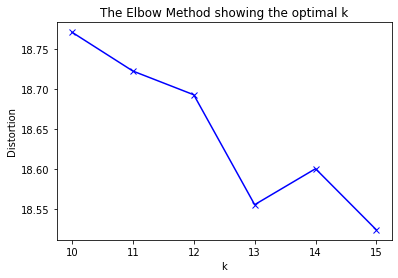

In [9]:
# k means determine k
distortions = []
p = 0
K = range(10,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(countUniBi)
    kmeanModel.fit(countUniBi)
    print("kmeans done for k=",k)
    distortions.append(sum(np.min(cdist(countUniBi, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / countUniBi.shape[0])
    
    cluster_map = pd.DataFrame()
    cluster_map['products_index'] = countUniBi.index.values
    cluster_map['cluster'] = kmeanModel.labels_
    cluster_sizes = []
    for i in range(0,k):
        cluster_sizes.append(len(cluster_map[cluster_map.cluster == i]))
    print(cluster_sizes)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### TfidfVectorizer Unigrams

In [12]:
products['description'] = products['shortDescription'].astype(str) + ' ' + products['longDescription'].astype(str)
products['description'] = products['description'].apply(lambda x: re.sub(r'\w*\d\w*', '',x))
manufacturerDum = pd.get_dummies(products.manufacturer,drop_first=True)
products1 = products[['esrb_everyone10', 'esrb_everyone', 'esrb_mature', 'esrb_pending','esrb_teen']]
products2 = pd.merge(products1,manufacturerDum,left_index=True,right_index=True)
vec = TfidfVectorizer(ngram_range=(1,1))
desc = vec.fit_transform(products.description)
descdf = pd.DataFrame.from_records(desc.toarray(),columns=vec.get_feature_names())
products3 = pd.merge(products2,descdf,left_index=True,right_index=True)
genreDum = pd.get_dummies(products.genre)
genreDum = genreDum.drop(['na'],axis=1)
products4 = pd.merge(products3,genreDum,left_index=True,right_index=True)
vec2 = TfidfVectorizer(ngram_range=(1,1))
esrbdesc = vec2.fit_transform(products.esrb_description)
esrbdescdf = pd.DataFrame.from_records(esrbdesc.toarray(),columns=vec2.get_feature_names())
tfidfUni = pd.merge(products4,esrbdescdf,left_index=True,right_index=True)

kmeans done for k= 10
[37, 73, 33, 45, 36, 41, 89, 47, 18, 17]
kmeans done for k= 11
[27, 33, 33, 58, 50, 41, 57, 31, 46, 40, 20]
kmeans done for k= 12
[16, 47, 56, 74, 33, 27, 54, 21, 31, 30, 11, 36]
kmeans done for k= 13
[23, 31, 56, 59, 26, 25, 47, 28, 26, 32, 21, 29, 33]
kmeans done for k= 14
[22, 28, 33, 27, 36, 50, 26, 36, 46, 40, 18, 23, 35, 16]
kmeans done for k= 15
[34, 47, 18, 22, 16, 34, 64, 25, 32, 18, 27, 14, 46, 25, 14]


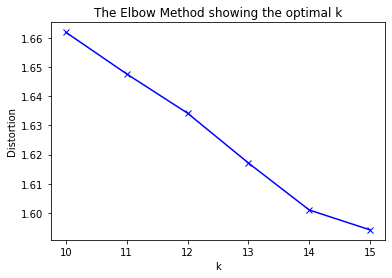

In [16]:
# k means determine k
distortions = []
p = 0
K = range(10,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(tfidfUni)
    kmeanModel.fit(tfidfUni)
    print("kmeans done for k=",k)
    distortions.append(sum(np.min(cdist(tfidfUni, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidfUni.shape[0])
    
    cluster_map = pd.DataFrame()
    cluster_map['products_index'] = tfidfUni.index.values
    cluster_map['cluster'] = kmeanModel.labels_
    cluster_sizes = []
    for i in range(0,k):
        cluster_sizes.append(len(cluster_map[cluster_map.cluster == i]))
    print(cluster_sizes)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Choosing **k=14** as the cluster size as a faint elbow can be seen at 14 cluster size.

### TfidfVectorizer Unigrams and Bigrams

In [7]:
products['description'] = products['shortDescription'].astype(str) + ' ' + products['longDescription'].astype(str)
products['description'] = products['description'].apply(lambda x: re.sub(r'\w*\d\w*', '',x))
manufacturerDum = pd.get_dummies(products.manufacturer,drop_first=True)
products1 = products[['esrb_everyone10', 'esrb_everyone', 'esrb_mature', 'esrb_pending','esrb_teen']]
products2 = pd.merge(products1,manufacturerDum,left_index=True,right_index=True)
vec = TfidfVectorizer(ngram_range=(1,2))
desc = vec.fit_transform(products.description)
descdf = pd.DataFrame.from_records(desc.toarray(),columns=vec.get_feature_names())
products3 = pd.merge(products2,descdf,left_index=True,right_index=True)
genreDum = pd.get_dummies(products.genre)
genreDum = genreDum.drop(['na'],axis=1)
products4 = pd.merge(products3,genreDum,left_index=True,right_index=True)
vec2 = TfidfVectorizer(ngram_range=(1,2))
esrbdesc = vec2.fit_transform(products.esrb_description)
esrbdescdf = pd.DataFrame.from_records(esrbdesc.toarray(),columns=vec2.get_feature_names())
tfidfUniBi = pd.merge(products4,esrbdescdf,left_index=True,right_index=True)

kmeans done for k= 10
[34, 46, 33, 20, 58, 43, 47, 101, 27, 27]
kmeans done for k= 11
[18, 27, 35, 32, 33, 52, 41, 27, 56, 89, 26]
kmeans done for k= 12
[27, 27, 34, 33, 49, 50, 16, 15, 31, 35, 92, 27]
kmeans done for k= 13
[48, 36, 53, 29, 56, 35, 21, 29, 22, 36, 15, 29, 27]
kmeans done for k= 14
[21, 42, 47, 36, 33, 78, 27, 15, 18, 31, 17, 11, 46, 14]
kmeans done for k= 15
[40, 18, 28, 15, 31, 53, 27, 19, 18, 28, 27, 33, 51, 33, 15]


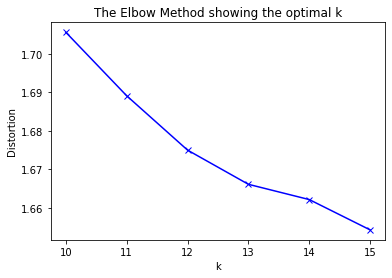

In [18]:
# k means determine k
distortions = []
p = 0
K = range(10,16)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(tfidfUniBi)
    kmeanModel.fit(tfidfUniBi)
    print("kmeans done for k=",k)
    distortions.append(sum(np.min(cdist(tfidfUniBi, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidfUniBi.shape[0])
    
    cluster_map = pd.DataFrame()
    cluster_map['products_index'] = tfidfUniBi.index.values
    cluster_map['cluster'] = kmeanModel.labels_
    cluster_sizes = []
    for i in range(0,k):
        cluster_sizes.append(len(cluster_map[cluster_map.cluster == i]))
    print(cluster_sizes)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We take **k=13** as the elbow in the above set of features with Unigrams and Bigrams in TFIDF.